# Introduction

The topic of analyzing toxicity in comments about AI-generated art is particularly relevant given the ethical debates surrounding AI art. AI-generated art has sparked significant controversy, especially regarding issues like copyright, creativity, and the role of AI in the artistic process. One of the key ethical concerns is that AI art is often trained on large datasets that may contain copyrighted works, raising questions about intellectual property rights. Many argue that AI-generated art undermines the value of human creativity, as AI models can replicate or mimic artistic styles without original inspiration or effort.

Given the complexity and sensitivity of these ethical discussions, it's unclear how much toxicity exists in the comments surrounding AI art on platforms like Twitter. Toxic comments, including insults, obscene language, identity attacks, and threats, may emerge in these conversations, but the extent and nature of these harmful remarks have not been fully explored. This project aims to explore and analyze the toxicity in comments related to AI-generated art, identifying the different forms of toxic behavior present in online discussions.

By analyzing these comments, we hope to better understand the prevalence and types of toxicity in the context of AI art, which can help inform strategies for improving online discourse and moderating harmful content. This exploration will provide insights into how ethical concerns surrounding AI and creativity are being expressed online and whether these discussions are being negatively impacted by toxic interactions.

The goal of this analysis is to predict the overall toxicity and its four specific subcategories—insult, obscene, identity attack, and threat—in comments discussing AI-generated art on Twitter. As AI art gains popularity, discussions around it can sometimes provoke strong reactions, and identifying the types of toxicity in these conversations is crucial. By categorizing toxicity into these four subtypes, we can better understand the nature of harmful content in AI art discussions.

This analysis helps to identify different forms of toxic behavior, such as insults, obscene language, attacks on identity, or threats, which can negatively affect the discourse surrounding AI art. By detecting these toxic comments, it becomes possible to implement targeted moderation, ensuring that conversations remain respectful and constructive. Understanding the specific nature of toxicity in AI art discussions allows for more effective interventions, such as flagging inappropriate comments or protecting users from harassment, thereby fostering a healthier online environment in the creative community.

The choice of using Decision Tree Regression for this analysis is based on its ability to handle complex, non-linear relationships between features and outcomes, which is crucial in predicting toxicity levels in comments. Decision trees are highly interpretable, allowing us to understand which specific words or phrases contribute to a comment being classified as toxic, insulting, or obscene. This transparency is valuable for improving content moderation strategies. Additionally, decision trees work well with imbalanced datasets, a common challenge in toxicity prediction, making them an effective tool for this task.

# Code

In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import gensim
import string
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.metrics import mean_squared_error

In [9]:
# Read the training and testing datasets
train_path = "../data/data-clean/cleaned_train.csv"
test_path = "../data/data-clean/all_data.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

## Overall Toxicity

First, we predicted the overall toxicity.

The workflow involves extracting the feature (comment_text) and target (target) columns from the train_df DataFrame. It then splits the data into training and validation sets (75% and 25%, respectively) using train_test_split, with a fixed random_state=5400 for reproducibility. Next, a CountVectorizer is used to convert the text data into a bag-of-words matrix with n-grams ranging from 1 to 2 and a maximum of 30,000 features. The fit_transform method is applied to the training data, while the transform method is used for the validation and test data, preparing them for model training and evaluation.

In [32]:
feature = train_df[['comment_text']]
output = train_df[['target']] 

In [33]:
X_train, X_val, y_train, y_val = train_test_split(feature, output, test_size=0.25, random_state=5400)

The choice of using Bag of Words (BoW) for text feature extraction in this analysis is due to its simplicity and effectiveness in representing text data. BoW transforms text into a matrix of word frequencies, capturing the presence or absence of words in a comment without considering their order. This method is particularly useful for toxicity prediction, as the occurrence of certain words or phrases can strongly correlate with a comment’s toxicity, regardless of the context in which they appear.

In [34]:
cnt_vec = CountVectorizer(ngram_range=(1, 2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['comment_text'])
bow_cv = cnt_vec.transform(X_val['comment_text'])
bow_test = cnt_vec.transform(test_df['text'])

The code performs hyperparameter tuning for a DecisionTreeRegressor by testing different combinations of max_depth and min_samples_leaf. It trains the model on the training data and evaluates its performance using Mean Squared Error (MSE) on both the training and validation sets. For each combination of parameters, the code tracks the model with the lowest validation error (best_model) and updates the best error (best_error). The goal is to find the model configuration that minimizes the validation error.

In [35]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_val['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.02784462237467328
Mean Squared Error on cv set:  0.026980733119644787
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.029137188516118854
Mean Squared Error on cv set:  0.028102991922892187
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03258898425985887
Mean Squared Error on cv set:  0.031059837402473818
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.026494316096529653
Mean Squared Error on cv set:  0.025918895654985046
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.028712339977638956
Mean Squared Error on cv set:  0.02740346788101636
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on

In [37]:
# Assuming you have the best_model already
# Get predictions using the best model on the training set
best_model_preds_train = best_model.predict(bow_train)

# Calculate MSE on training set
best_model_mse_train = mean_squared_error(y_train['target'], best_model_preds_train)
print("Best Model MSE on Training Set: ", best_model_mse_train)

# Get predictions using the best model on the validation set
best_model_preds_cv = best_model.predict(bow_cv)

# Calculate MSE on validation set
best_model_mse_cv = mean_squared_error(y_val['target'], best_model_preds_cv)
print("Best Model MSE on Validation Set: ", best_model_mse_cv)

Best Model MSE on Training Set:  0.02561612983816253
Best Model MSE on Validation Set:  0.02529996771561696


In [7]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

The goal here is to understand which specific words contribute most to the model's decision-making process regarding toxicity. This insight can help in improving the model, interpreting its behavior, and potentially informing interventions (e.g., flagging or filtering specific words associated with toxicity).

In [8]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.392428
idiot,0.182188
crap,0.094509
shit,0.087531
fuck,0.080585
white,0.060375
damn,0.053492
need,0.009294
racist,0.008793
state,0.007312


Now, we predict the toxicity scores for testing set.

In [9]:
test_preds = best_model.predict(bow_test)

In [ ]:
test_df['predicted_target'] = test_preds

## Obscene

Obscene language is frequently used to express strong disapproval or hostility, further escalating the negative tone of online discussions surrounding AI art.

In [38]:
feature = train_df[['comment_text']]
output = train_df[['obscene']] 

In [39]:
X_train, X_val, y_train, y_val = train_test_split(feature, output, test_size=0.25, random_state=5400)
cnt_vec = CountVectorizer(ngram_range=(1, 2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['comment_text'])
bow_cv = cnt_vec.transform(X_val['comment_text'])
bow_test = cnt_vec.transform(test_df['text'])

In [40]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['obscene'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_val['obscene'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.003852674675173767
Mean Squared Error on cv set:  0.0031025722721113717
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.0053546552422458924
Mean Squared Error on cv set:  0.004368470124842318
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.005453124413820993
Mean Squared Error on cv set:  0.004465980971537929
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.003232896827505672
Mean Squared Error on cv set:  0.002882715645971403
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.005340351866792326
Mean Squared Error on cv set:  0.004368025956088693
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Err

In [41]:
# Assuming you have the best_model already
# Get predictions using the best model on the training set
best_model_preds_train = best_model.predict(bow_train)

# Calculate MSE on training set
best_model_mse_train = mean_squared_error(y_train['obscene'], best_model_preds_train)
print("Best Model MSE on Training Set: ", best_model_mse_train)

# Get predictions using the best model on the validation set
best_model_preds_cv = best_model.predict(bow_cv)

# Calculate MSE on validation set
best_model_mse_cv = mean_squared_error(y_val['obscene'], best_model_preds_cv)
print("Best Model MSE on Validation Set: ", best_model_mse_cv)

Best Model MSE on Training Set:  0.0030279016719948703
Best Model MSE on Validation Set:  0.002653976805381491


In [14]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [15]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
fuck,0.294531
shit,0.239410
damn,0.127157
crap,0.124664
ass,0.108923
idiot,0.038333
darn,0.031181
work,0.015108
like,0.007912
give,0.005974


In [16]:
test_preds = best_model.predict(bow_test)
test_df['predicted_obscene'] = test_preds

## Identity Attack

Beyond general obscenities, identity attacks represent a more personal form of toxicity, where individuals may target others based on their background, beliefs, or affiliations, deepening the divide in these conversations.

In [20]:
feature = train_df[['comment_text']]
output = train_df[['identity_attack']]

In [21]:
X_train, X_val, y_train, y_val = train_test_split(feature, output, test_size=0.25, random_state=5400)
cnt_vec = CountVectorizer(ngram_range=(1, 2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['comment_text'])
bow_cv = cnt_vec.transform(X_val['comment_text'])
bow_test = cnt_vec.transform(test_df['text'])

In [22]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['identity_attack'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_val['identity_attack'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.0038778977083623084
Mean Squared Error on cv set:  0.0038034694192178886
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.004159742796016517
Mean Squared Error on cv set:  0.0039973452198680684
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.0048683893003081775
Mean Squared Error on cv set:  0.004581649324471106
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.003636946636616474
Mean Squared Error on cv set:  0.0036565782122243485
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.004068479469110963
Mean Squared Error on cv set:  0.003919419556340099
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared 

In [ ]:
# Assuming you have the best_model already
# Get predictions using the best model on the training set
best_model_preds_train = best_model.predict(bow_train)

# Calculate MSE on training set
best_model_mse_train = mean_squared_error(y_train['identity_attack'], best_model_preds_train)
print("Best Model MSE on Training Set: ", best_model_mse_train)

# Get predictions using the best model on the validation set
best_model_preds_cv = best_model.predict(bow_cv)

# Calculate MSE on validation set
best_model_mse_cv = mean_squared_error(y_val['identity_attack'], best_model_preds_cv)
print("Best Model MSE on Validation Set: ", best_model_mse_cv)

Best Model MSE on Training Set:  0.003636946636616474
Best Model MSE on Validation Set:  0.0036565782122243485


In [20]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [21]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]
test_preds = best_model.predict(bow_test)
test_df['predicted_identity_attack'] = test_preds

In [22]:
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
white,0.409359
gay,0.257668
black,0.069388
homosexu,0.069088
muslim,0.059689
white hous,0.034622
white peopl,0.025212
go,0.021452
nativ,0.015553
dont,0.014900


## Insult

One of the primary forms of toxicity in AI art discussions is the use of insults, which often involve derogatory language aimed at discrediting others' opinions or contributions.

In [24]:
feature = train_df[['comment_text']]
output = train_df[['insult']] 
X_train, X_val, y_train, y_val = train_test_split(feature, output, test_size=0.25, random_state=5400)
cnt_vec = CountVectorizer(ngram_range=(1, 2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['comment_text'])
bow_cv = cnt_vec.transform(X_val['comment_text'])
bow_test = cnt_vec.transform(test_df['text'])

In [25]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['insult'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_val['insult'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.020468556814947428
Mean Squared Error on cv set:  0.019534348686417572
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.02153318949652013
Mean Squared Error on cv set:  0.020608162713028344
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.024885609638873728
Mean Squared Error on cv set:  0.023397247783102332
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.019576115411698146
Mean Squared Error on cv set:  0.019167159895962498
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.021255129675314254
Mean Squared Error on cv set:  0.020321076624613202
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error 

In [26]:
# Assuming you have the best_model already
# Get predictions using the best model on the training set
best_model_preds_train = best_model.predict(bow_train)

# Calculate MSE on training set
best_model_mse_train = mean_squared_error(y_train['insult'], best_model_preds_train)
print("Best Model MSE on Training Set: ", best_model_mse_train)

# Get predictions using the best model on the validation set
best_model_preds_cv = best_model.predict(bow_cv)

# Calculate MSE on validation set
best_model_mse_cv = mean_squared_error(y_val['insult'], best_model_preds_cv)
print("Best Model MSE on Validation Set: ", best_model_mse_cv)

Best Model MSE on Training Set:  0.018787716744211213
Best Model MSE on Validation Set:  0.01848799847025937


In [25]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [26]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.430534
idiot,0.211666
ridicul,0.065206
crap,0.058586
ignor,0.056680
dumb,0.056186
fuck,0.054561
one,0.012351
need,0.010200
like,0.008296


In [27]:
test_preds = best_model.predict(bow_test)
test_df['predicted_insult'] = test_preds

## Threat

In the most severe cases, some comments may escalate to threats, where individuals express harmful intentions or intimidation towards others, creating a toxic and potentially unsafe environment in AI art discussions.

In [27]:
feature = train_df[['comment_text']]
output = train_df[['threat']] 
X_train, X_val, y_train, y_val = train_test_split(feature, output, test_size=0.25, random_state=5400)
cnt_vec = CountVectorizer(ngram_range=(1, 2), max_features=6000)
bow_train = cnt_vec.fit_transform(X_train['comment_text'])
bow_cv = cnt_vec.transform(X_val['comment_text'])
bow_test = cnt_vec.transform(test_df['text'])

In [28]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['threat'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_val['threat'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.0020159770385689193
Mean Squared Error on cv set:  0.0022702696206550023
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.0020591539625161356
Mean Squared Error on cv set:  0.002256625227283155
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.0022558277879534566
Mean Squared Error on cv set:  0.0024958560136284524
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.0019496492466681882
Mean Squared Error on cv set:  0.0022669194316674024
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.0020451886535109483
Mean Squared Error on cv set:  0.002245748640190827
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squar

In [29]:
# Assuming you have the best_model already
# Get predictions using the best model on the training set
best_model_preds_train = best_model.predict(bow_train)

# Calculate MSE on training set
best_model_mse_train = mean_squared_error(y_train['threat'], best_model_preds_train)
print("Best Model MSE on Training Set: ", best_model_mse_train)

# Get predictions using the best model on the validation set
best_model_preds_cv = best_model.predict(bow_cv)

# Calculate MSE on validation set
best_model_mse_cv = mean_squared_error(y_val['threat'], best_model_preds_cv)
print("Best Model MSE on Validation Set: ", best_model_mse_cv)

Best Model MSE on Training Set:  0.0020376871141131576
Best Model MSE on Validation Set:  0.0022378776422451053


In [30]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [31]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names_out()
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
kill,0.547052
shoot,0.277411
death,0.073833
shot,0.043069
gun,0.019991
die,0.018149
head,0.015724
peopl,0.004771
poop,0.000000
populac,0.000000


In [32]:
test_preds = best_model.predict(bow_test)
test_df['predicted_threat'] = test_preds
test_df.to_csv('../data/data-predict/DecisionTreeRegressor_test_predictions.csv', index=False)

## Visualizations

### Overall Toxicity

In [33]:
print(test_df['predicted_target'].describe())

count    342.000000
mean       0.119709
std        0.168899
min        0.069632
25%        0.069632
50%        0.069632
75%        0.069632
max        0.758003
Name: predicted_target, dtype: float64


The histogram illustrates the distribution of predicted toxicity scores, where the x-axis represents the predicted toxicity levels ranging from 0 (non-toxic) to 1 (toxic), and the y-axis shows the frequency of comments within each range. The data reveals that most comments are predicted to have low toxicity scores, with a concentration around 0.1. This suggests that the majority of comments in the dataset are considered non-toxic, with only a small proportion predicted to be more toxic. This distribution reflects a broader trend in online discussions, where toxic comments tend to be less frequent than non-toxic ones.

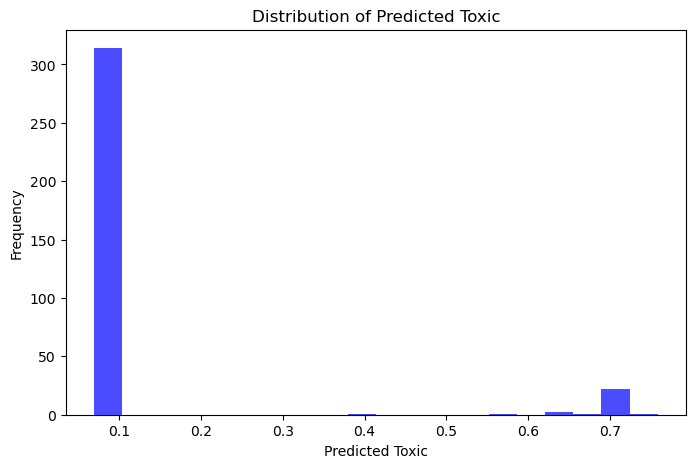

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(test_df['predicted_target'], bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Predicted Toxic")
plt.xlabel("Predicted Toxic")
plt.ylabel("Frequency")
plt.show()

We simply check the non-toxic comments and toxic comments, trying to find the main difference between them.

In [35]:
top_predictions = test_df.sort_values(by='predicted_target', ascending=False).head(10)
print(top_predictions[['text', 'predicted_target']])

low_predictions = test_df.sort_values(by='predicted_target', ascending=True).head(10)
print(low_predictions[['text', 'predicted_target']])

                                                  text  predicted_target
0    thefrogsoupram bluerei naegiko didnt consent a...          0.758003
18   everyon support ai look good monster planet fu...          0.700567
190  talanhorn hate perform hate ai protect dont ne...          0.700567
192  rt sladeneverdi shit look like made ai disney ...          0.700567
193  seen someon describ clever ai art prompt cleve...          0.700567
199  shit look like made ai disney becom hous soull...          0.700567
120  monachikosx charismaticgeto alreadi put place ...          0.700567
234  art verg death soulless ai shit art art feel code          0.700567
236  ai creator lie shit fuck ugliest soulless bull...          0.700567
255  quit soulless plu look like shit id say ai stu...          0.700567
                                                  text  predicted_target
171    one hand ai art exploit hand least ruin environ          0.069632
228                            call ai soulless rea

The image is a word cloud representing the most frequent words in highly toxic comments. In this word cloud, the size of each word is proportional to its frequency in the toxic comments, with larger words appearing more often. Words like "shit," "fuck," "soulless," and "kill" stand out, indicating that these terms are commonly associated with high levels of toxicity in the comments. Other words such as "human," "artist," and "steal" also appear, reflecting the types of aggressive and harmful language used to criticize AI art or its creators. This visualization highlights the specific language patterns that contribute to toxic interactions in online discussions. The presence of these words suggests that many toxic comments express extreme negative sentiments, often targeting individuals or broader concepts in the AI art community.

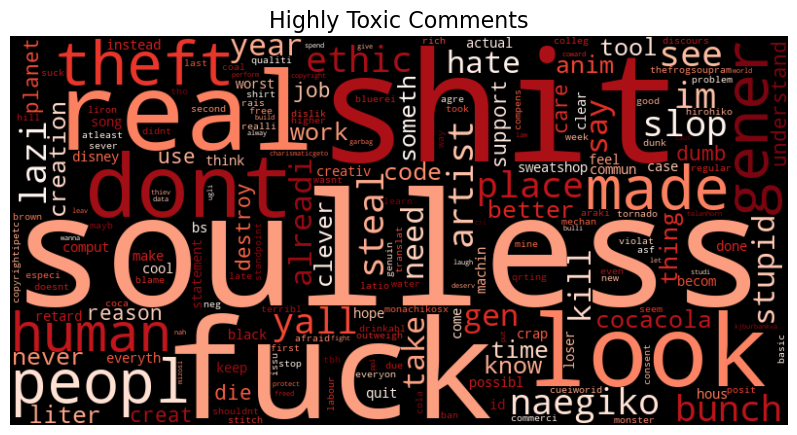

In [36]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Set thresholds for toxicity
high_toxic_threshold = 0.5  # Adjusted threshold

# Select high toxicity comments
high_toxic_comments = test_df[test_df['predicted_target'] > high_toxic_threshold]['text'].values
high_toxic_text = " ".join(high_toxic_comments)

# Custom stopwords: Add "ai" and "art" to default stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["ai", "art"])  # Add words to remove

# Check if text is empty before generating word clouds
if len(high_toxic_text.strip()) > 0:
    # Generate word cloud for highly toxic comments
    high_toxic_wc = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap='Reds',
        stopwords=custom_stopwords  # Apply custom stopwords
    ).generate(high_toxic_text)
else:
    print("No high toxic comments available for word cloud!")

# Plot the word clouds
plt.figure(figsize=(16, 8))

# Plot highly toxic comments word cloud
if len(high_toxic_text.strip()) > 0:
    plt.subplot(1, 2, 1)
    plt.title("Highly Toxic Comments", fontsize=16)
    plt.imshow(high_toxic_wc, interpolation='bilinear')
    plt.axis("off")

plt.tight_layout()
plt.show()


### Obscene

In [37]:
print(test_df['predicted_obscene'].describe())

count    342.000000
mean       0.056506
std        0.163939
min        0.009150
25%        0.009150
50%        0.009150
75%        0.009150
max        0.648587
Name: predicted_obscene, dtype: float64


The histogram illustrates the distribution of predicted obscenity scores in the dataset. The x-axis represents the predicted obscenity values, ranging from 0 (non-obscene) to 1 (obscene), and the y-axis shows the frequency of comments falling into each range. Similar to the toxicity distribution, the graph shows that most of the comments are predicted to have very low obscenity scores, with the majority concentrated around 0.0. A small number of comments are predicted to have higher obscenity scores, with a few falling in the range of 0.3 to 0.6. This suggests that obscene comments are relatively rare in this dataset, with most comments being classified as non-obscene. The distribution again reflects an imbalanced nature, where non-obscene comments dominate, and only a small proportion of comments are predicted as obscene.

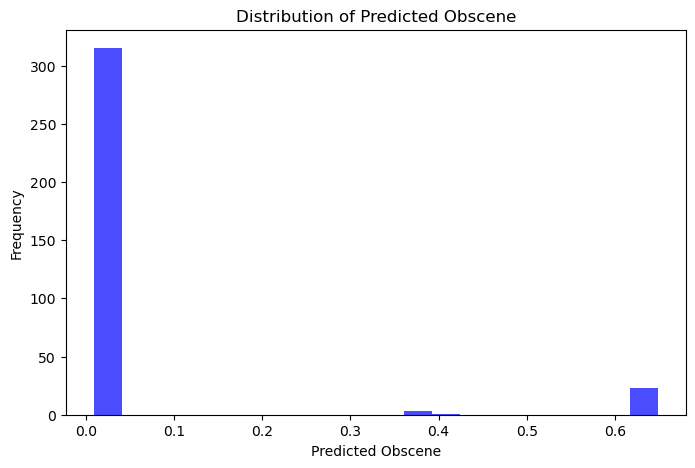

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(test_df['predicted_obscene'], bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Predicted Obscene")
plt.xlabel("Predicted Obscene")
plt.ylabel("Frequency")
plt.show()

The word cloud represents the most frequent words in highly obscene comments, with the size of each word reflecting its frequency in the dataset. Words such as "fuck," "shit," "soulless," and "steal" are prominent, highlighting the use of vulgar and offensive language commonly associated with obscene comments. Other words like "human," "artist," "theft," and "look" appear frequently, reflecting the intense criticism and negativity directed at individuals or concepts in the discussion. This visualization indicates that highly obscene comments in the dataset tend to involve harsh and explicit language, often targeting others with insults or disparaging remarks. It helps to understand the specific language that fuels the toxicity and obscenity in AI art discussions.

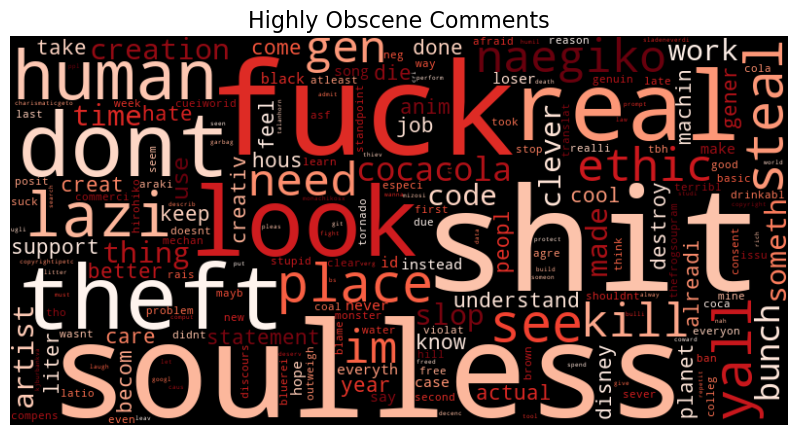

In [39]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Set thresholds for toxicity
high_toxic_threshold = 0.5  # Adjusted threshold

# Select high toxicity comments
high_obscene_comments = test_df[test_df['predicted_obscene'] > high_toxic_threshold]['text'].values
high_obscene_text = " ".join(high_obscene_comments)

# Custom stopwords: Add "ai" and "art" to default stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["ai", "art"])  # Add words to remove

# Check if text is empty before generating word clouds
if len(high_obscene_text.strip()) > 0:
    # Generate word cloud for highly toxic comments
    high_toxic_wc = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap='Reds',
        stopwords=custom_stopwords  # Apply custom stopwords
    ).generate(high_obscene_text)
else:
    print("No high obscene comments available for word cloud!")

# Plot the word clouds
plt.figure(figsize=(16, 8))

# Plot highly toxic comments word cloud
if len(high_obscene_text.strip()) > 0:
    plt.subplot(1, 2, 1)
    plt.title("Highly Obscene Comments", fontsize=16)
    plt.imshow(high_toxic_wc, interpolation='bilinear')
    plt.axis("off")

plt.tight_layout()
plt.show()

### Identity Attack

In [40]:
print(test_df['predicted_identity_attack'].describe())

count    342.000000
mean       0.012269
std        0.005699
min        0.011833
25%        0.011833
50%        0.011833
75%        0.011833
max        0.086471
Name: predicted_identity_attack, dtype: float64


The histogram illustrates the distribution of predicted identity attack scores. The x-axis represents the predicted identity attack values, ranging from 0 (no identity attack) to 1 (high identity attack), and the y-axis shows the frequency of comments within each score range. The majority of comments are predicted to have very low identity attack scores, concentrated around 0.01. This suggests that identity attacks are rare in the dataset, as all comments are classified with minimal or no identity-related attacks. 

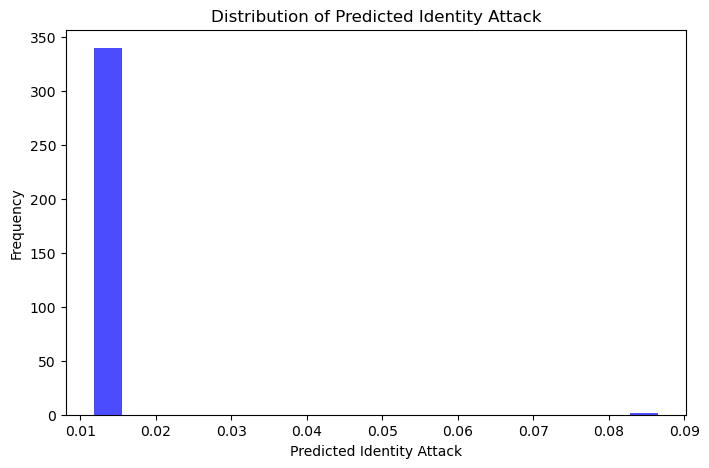

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(test_df['predicted_identity_attack'], bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Predicted Identity Attack")
plt.xlabel("Predicted Identity Attack")
plt.ylabel("Frequency")
plt.show()

We can also observe that there is no enough words for us to build a word cloud for identity attack.

In [42]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Set thresholds for toxicity
high_toxic_threshold = 0.5  # Adjusted threshold

# Select high toxicity comments
high_ia_comments = test_df[test_df['predicted_identity_attack'] > high_toxic_threshold]['text'].values
high_ia_text = " ".join(high_ia_comments)

# Custom stopwords: Add "ai" and "art" to default stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["ai", "art"])  # Add words to remove

# Check if text is empty before generating word clouds
if len(high_ia_text.strip()) > 0:
    # Generate word cloud for highly toxic comments
    high_toxic_wc = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap='Reds',
        stopwords=custom_stopwords  # Apply custom stopwords
    ).generate(high_ia_text)
else:
    print("No high identity attack comments available for word cloud!")

# Plot the word clouds
plt.figure(figsize=(16, 8))

# Plot highly toxic comments word cloud
if len(high_ia_text.strip()) > 0:
    plt.subplot(1, 2, 1)
    plt.title("Highly Identity Attack Comments", fontsize=16)
    plt.imshow(high_toxic_wc, interpolation='bilinear')
    plt.axis("off")

plt.tight_layout()
plt.show()

No high identity attack comments available for word cloud!


<Figure size 1600x800 with 0 Axes>

### Insult

In [43]:
print(test_df['predicted_insult'].describe())

count    342.000000
mean       0.071250
std        0.097704
min        0.050236
25%        0.050236
50%        0.050236
75%        0.050236
max        0.714464
Name: predicted_insult, dtype: float64


The histogram represents the distribution of predicted insult scores, where the x-axis shows the predicted insult values ranging from 0 (no insult) to 1 (high insult), and the y-axis displays the frequency of comments within each predicted range. Most of the comments are predicted to have low insult scores, concentrated around 0.1, indicating that the majority of comments are classified as non-insulting or mildly insulting. There are a few comments with slightly higher predicted insult scores, but these are relatively rare. This suggests that, while insults do appear in the dataset, they are not common, with most comments being classified as low in insult content.

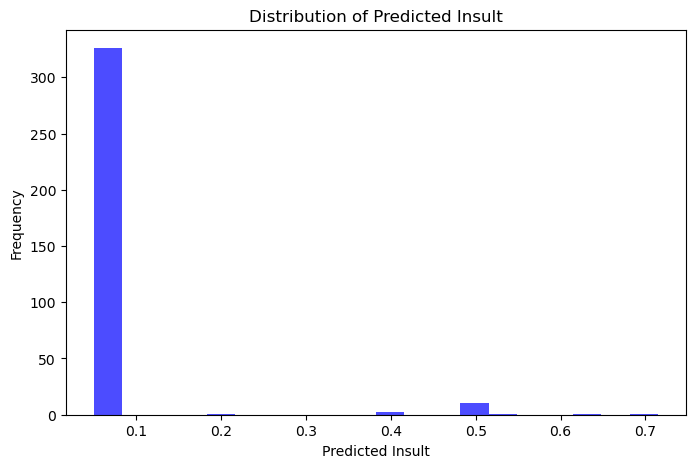

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(test_df['predicted_insult'], bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Predicted Insult")
plt.xlabel("Predicted Insult")
plt.ylabel("Frequency")
plt.show()

The word cloud represents the most frequent words in highly insulting comments, with the size of each word reflecting its frequency. Words like "fuck," "soulless," "shit," and "steal" dominate the cloud, indicating the use of strong derogatory language. Other words such as "artist," "people," "theft," and "ethic" also appear prominently, showing that insults are often directed at individuals or concepts related to AI art, such as creators and ethical concerns. This visualization highlights the aggressive tone and personal nature of insults in AI art discussions, where individuals or their work are often targeted with harsh, offensive language.

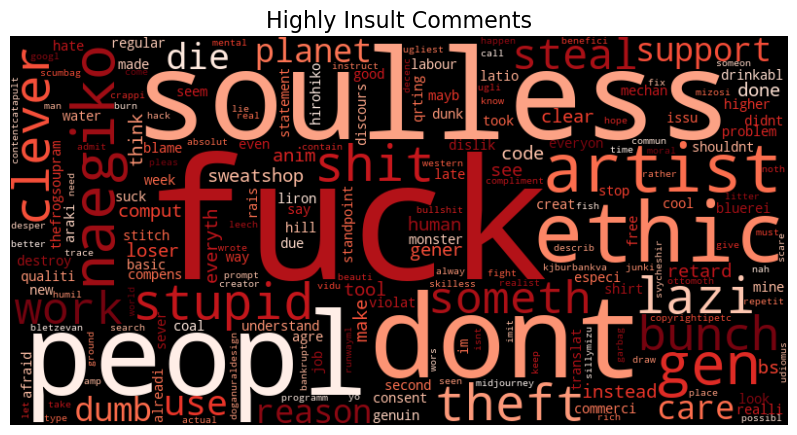

In [45]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Set thresholds for toxicity
high_toxic_threshold = 0.5  # Adjusted threshold

# Select high toxicity comments
high_insult_comments = test_df[test_df['predicted_insult'] > high_toxic_threshold]['text'].values
high_insult_text = " ".join(high_insult_comments)

# Custom stopwords: Add "ai" and "art" to default stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["ai", "art"])  # Add words to remove

# Check if text is empty before generating word clouds
if len(high_insult_text.strip()) > 0:
    # Generate word cloud for highly toxic comments
    high_toxic_wc = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap='Reds',
        stopwords=custom_stopwords  # Apply custom stopwords
    ).generate(high_insult_text)
else:
    print("No high insult comments available for word cloud!")

# Plot the word clouds
plt.figure(figsize=(16, 8))

# Plot highly toxic comments word cloud
if len(high_insult_text.strip()) > 0:
    plt.subplot(1, 2, 1)
    plt.title("Highly Insult Comments", fontsize=16)
    plt.imshow(high_toxic_wc, interpolation='bilinear')
    plt.axis("off")

plt.tight_layout()
plt.show()

### Threat

In [46]:
print(test_df['predicted_threat'].describe())

count    342.000000
mean       0.011625
std        0.021393
min        0.005053
25%        0.005053
50%        0.005053
75%        0.005053
max        0.088155
Name: predicted_threat, dtype: float64


The histogram shows that there are no comments predicted to contain threats. Most of the comments in the dataset have predicted threat scores close to 0, indicating that the overwhelming majority of comments do not involve threatening language. The frequency of higher predicted threat scores is extremely low, with only a small number of comments having slightly elevated threat levels, but still keep in a low range. This suggests that, in this specific dataset, threats are virtually nonexistent, and the overall level of threatening language is very rare.

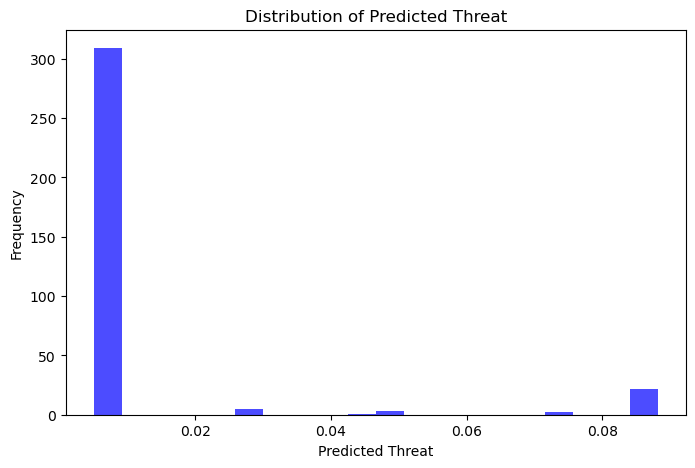

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(test_df['predicted_threat'], bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Predicted Threat")
plt.xlabel("Predicted Threat")
plt.ylabel("Frequency")
plt.show()

In [48]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Set thresholds for toxicity
high_toxic_threshold = 0.5  # Adjusted threshold

# Select high toxicity comments
high_threat_comments = test_df[test_df['predicted_threat'] > high_toxic_threshold]['text'].values
high_threat_text = " ".join(high_threat_comments)

# Custom stopwords: Add "ai" and "art" to default stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["ai", "art"])  # Add words to remove

# Check if text is empty before generating word clouds
if len(high_threat_text.strip()) > 0:
    # Generate word cloud for highly toxic comments
    high_toxic_wc = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap='Reds',
        stopwords=custom_stopwords  # Apply custom stopwords
    ).generate(high_threat_text)
else:
    print("No high threat comments available for word cloud!")

# Plot the word clouds
plt.figure(figsize=(16, 8))

# Plot highly toxic comments word cloud
if len(high_threat_text.strip()) > 0:
    plt.subplot(1, 2, 1)
    plt.title("Highly Threat Comments", fontsize=16)
    plt.imshow(high_toxic_wc, interpolation='bilinear')
    plt.axis("off")

plt.tight_layout()
plt.show()

No high threat comments available for word cloud!


<Figure size 1600x800 with 0 Axes>

### Summary of Toxicity Subcategories in AI Art Discussions

The plot shows the relationships between different toxicity categories—overall toxicities, obscenity, identity attack, insult, and threat—by visualizing their pairwise correlations along with the predicted overall toxicity score (target). Each point represents a comment, and its color reflects the predicted target score, ranging from low (blue) to high toxicity (red). The scatter plots reveal that most toxicity categories have low correlation with each other, although some, like insult and identity attack, show more variability. The predicted_threat category is notably sparse, indicating that threats are rare in the dataset. This visualization helps understand how different forms of toxicity interact and contribute to the overall toxicity of the comments.

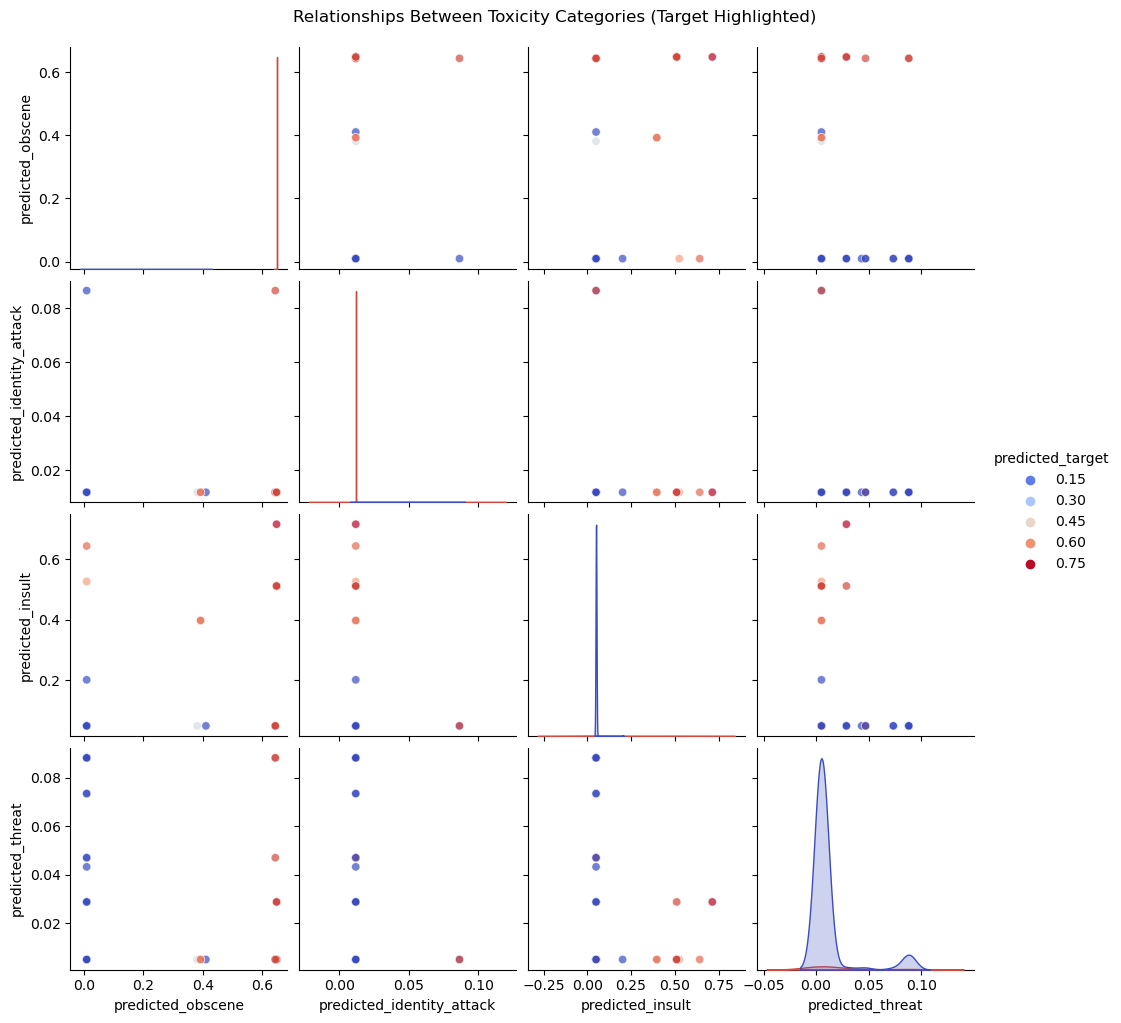

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

toxic_categories = ['predicted_obscene', 'predicted_identity_attack', 'predicted_insult', 'predicted_threat']

sns.pairplot(data=test_df, vars=toxic_categories, diag_kind='kde',
             hue='predicted_target', palette='coolwarm', plot_kws={'alpha': 0.7})
plt.suptitle("Relationships Between Toxicity Categories (Target Highlighted)", y=1.02)
plt.show()

The bar chart illustrates the proportion of comments with high toxicity scores (greater than 0.5) for each toxicity category. The x-axis represents the different toxicity categories—Predicted Toxicity, Predicted Obscene, Predicted Insult, Predicted Identity Attack, and Predicted Threat. The y-axis shows the proportion of comments that have a predicted score greater than 0.5 for each category.

The chart reveals that the proportions of high scores are very low across all categories. For example, only 8% of comments are predicted to have high toxicity, and the proportions for the other categories—obscenity, insult, identity attack, and threat—are even lower, ranging from 0% to 7%. This suggests that highly toxic comments are rare in each of the specific categories, with the vast majority of comments being classified with lower toxicity scores.

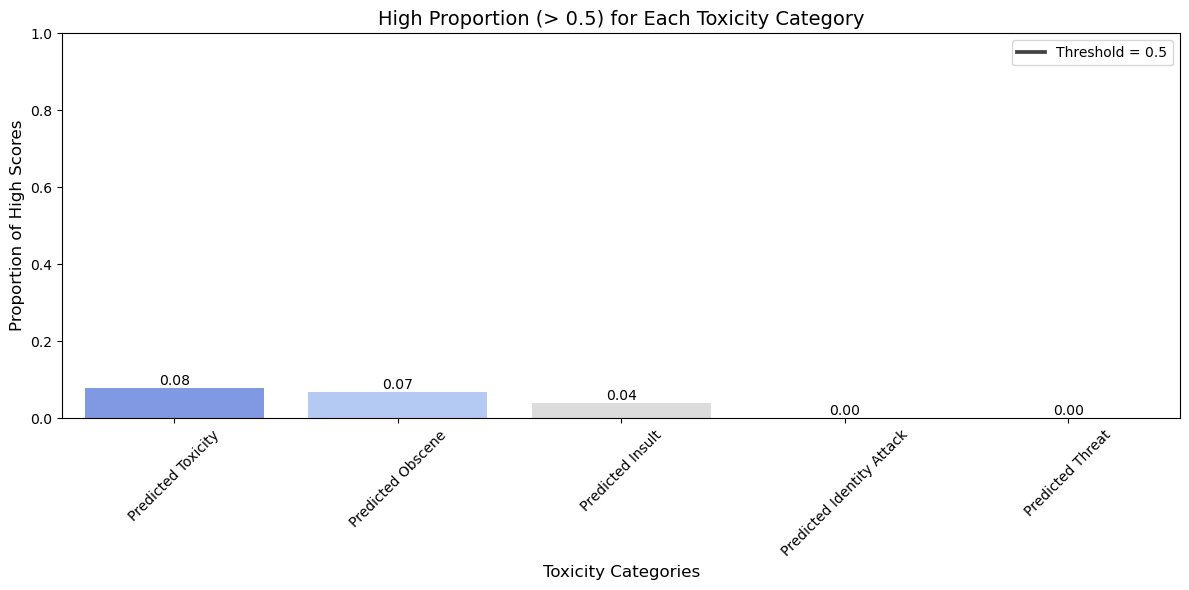

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the threshold
threshold = 0.5

# Toxic categories to analyze
toxic_categories = {
    'predicted_target': 'Predicted Toxicity',
    'predicted_obscene': 'Predicted Obscene',
    'predicted_identity_attack': 'Predicted Identity Attack',
    'predicted_insult': 'Predicted Insult',
    'predicted_threat': 'Predicted Threat'
}

# Calculate the high proportion for each category
high_proportions = {}
for category, label in toxic_categories.items():
    high_proportions[label] = (test_df[category] > threshold).mean()

# Convert to a sorted list for visualization
high_proportions_sorted = dict(sorted(high_proportions.items(), key=lambda x: x[1], reverse=True))

# Plot the high proportions
plt.figure(figsize=(12, 6))
bars = sns.barplot(
    x=list(high_proportions_sorted.keys()),
    y=list(high_proportions_sorted.values()),
    palette='coolwarm'
)

# Add titles and labels
plt.title("High Proportion (> 0.5) for Each Toxicity Category", fontsize=14)
plt.ylabel("Proportion of High Scores", fontsize=12)
plt.xlabel("Toxicity Categories", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Add bar labels to show values
for bar in bars.patches:
    value = bar.get_height()
    bars.annotate(f"{value:.2f}", (bar.get_x() + bar.get_width() / 2, value), 
                  ha='center', va='bottom', fontsize=10, color='black')

# Add legend
plt.legend(["Threshold = 0.5"], loc='upper right', fontsize=10, frameon=True)

# Show plot
plt.tight_layout()
plt.show()

In the context of a decision tree model, the results of this chart have significant real-world implications. Decision trees work by making a series of decisions based on feature values, and they are often used to classify or predict outcomes. Here, the chart illustrates how different categories of toxicity (such as overall toxicity, obscenity, insult, identity attack, and threat) are distributed, particularly showing that high toxicity scores (greater than 0.5) are rare across all categories.

From a practical standpoint, this suggests that the vast majority of comments on AI art are classified as non-toxic or only mildly toxic. This insight can help inform content moderation strategies, where the focus could be placed on a small proportion of comments that exhibit high levels of toxicity. In real-world applications like online platforms or social media, where toxicity management is crucial, understanding the relative rarity of highly toxic comments can help optimize resources, directing attention to the most harmful interactions while acknowledging that most interactions are non-toxic.

Additionally, decision trees provide transparency in the model's decision-making process, meaning that content moderation teams can understand the specific features or conditions that lead to a comment being classified as toxic, obscene, insulting, or threatening. This can help in refining guidelines for automated moderation or assist human moderators in making more informed decisions when handling user comments.